# **[Sentiment] Submission 1 BFDL - Maulana Seno Aji Yudhantara**
## Proyek Analisis Sentimen Review Aplikasi Wondr by BNI
Notebook ini berisi proses pelatihan model untuk analisis sentimen berdasarkan review pengguna dari aplikasi **Wondr by BNI** yang diambil dari Play Store. Proses meliputi: pemrosesan data, ekstraksi fitur, pelabelan, pelatihan model, evaluasi, dan inference.


# **1. Import Library**
Pada tahap ini, saya mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk scraping komentar.

In [108]:
# Manipulasi dan visualisasi data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Preprocessing
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Ekstraksi fitur
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Split dan evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Model ML dan DL
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Menyimpan model
import joblib
from joblib import load

# WordCloud
from wordcloud import WordCloud


# **2. Import Dataset**

In [51]:
df = pd.read_csv("reviews_wondr_bni.csv")

# **3. Exploratory Data Analysis (EDA)**

## Informasi Umum Dataset

In [52]:
# Info dasar dataset
print("Jumlah data:", df.shape)
print("Jumlah kolom:", df.shape[1])
df.info()
df.head()


Jumlah data: (39316, 4)
Jumlah kolom: 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39316 entries, 0 to 39315
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  39316 non-null  object
 1   content   39316 non-null  object
 2   score     39316 non-null  int64 
 3   at        39316 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


,userName,content,score,at
0,Pengguna Google,bagus cuma agak lelet,4,2025-05-21 09:36:49
1,Pengguna Google,bagus mantaf,5,2025-05-21 09:24:05
2,Pengguna Google,"sampe kapan gangguan sistim terus, mau daftar ...",3,2025-05-21 09:14:49
3,Pengguna Google,Transaksi cepat dan mudah berkat aplikasi ini....,5,2025-05-21 09:06:12
4,Pengguna Google,wonder lebih bagus dari BNI mobile,5,2025-05-21 09:01:32


## Distribusi Skor Rating

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12136\1764469178.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='score', palette='viridis')


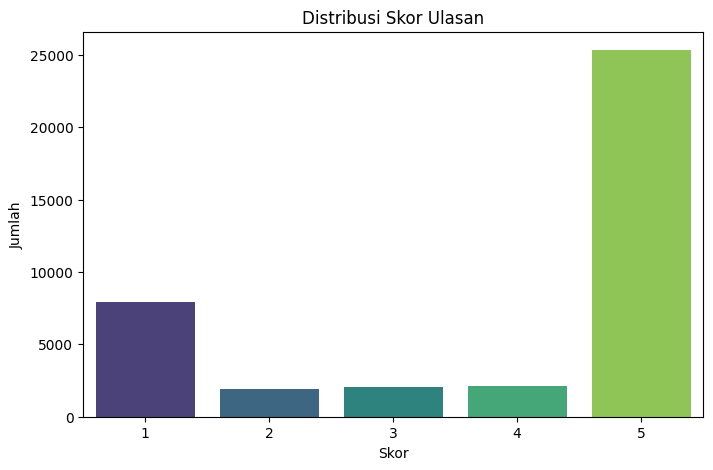

In [53]:
# Distribusi score ulasan
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='score', palette='viridis')
plt.title('Distribusi Skor Ulasan')
plt.xlabel('Skor')
plt.ylabel('Jumlah')
plt.show()


## Pisahkan Ulasan Positif & Negatif
Asumsi:
- Skor 4 dan 5 = positif
- Skor 1 dan 2 = negatif
- Skor 3 = netral (optional untuk dibuang atau tidak diproses sekarang)

In [54]:
# Pisahkan ulasan positif dan negatif
positive_reviews = df[df['score'] >= 4]
negative_reviews = df[df['score'] <= 2]

print(f"Jumlah ulasan positif: {len(positive_reviews)}")
print(f"Jumlah ulasan negatif: {len(negative_reviews)}")


Jumlah ulasan positif: 27439
Jumlah ulasan negatif: 9846


## WordCloud untuk ulasan Positif & Negatif

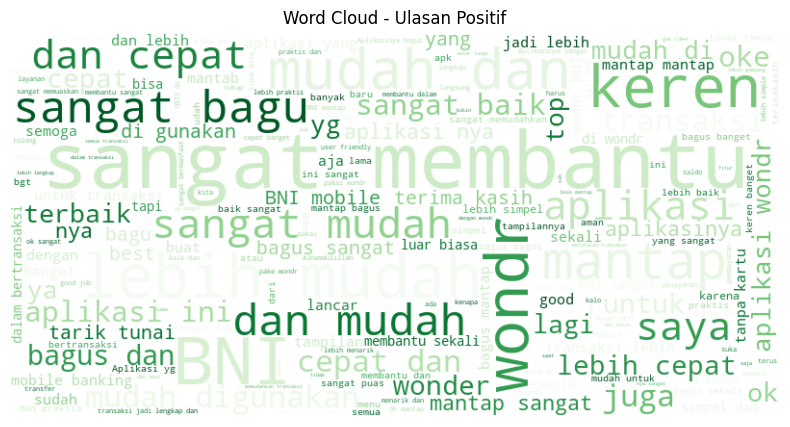

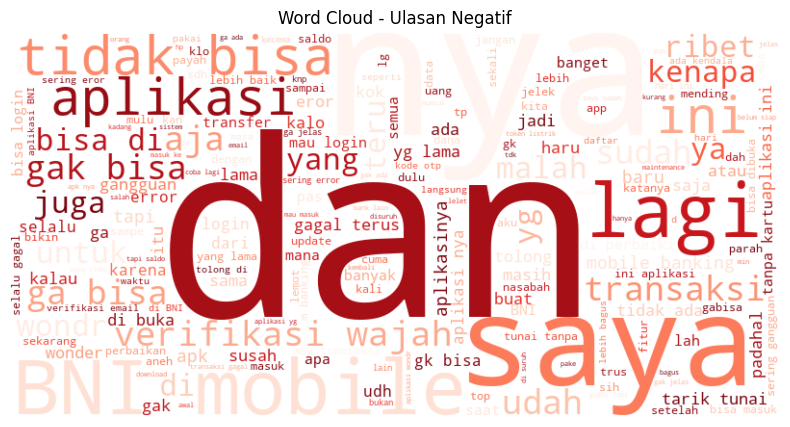

In [55]:
# Gabungkan teks ulasan untuk wordcloud
text_pos = " ".join(positive_reviews['content'].astype(str))
text_neg = " ".join(negative_reviews['content'].astype(str))

# WordCloud Positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(text_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ulasan Positif')
plt.show()

# WordCloud Negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_neg)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ulasan Negatif')
plt.show()


# **4. Preprocessing**

## a. Normalisasi Text
- Mengubah teks menjadi huruf kecil (lowercase)
- Menghapus angka, tanda baca, simbol, mention, hashtag, link
- Menghapus whitespace berlebih

In [56]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text


## b. Tokenisasi
- Memecah kalimat menjadi kata menggunakan **split()**

In [57]:
def tokenize_text(text):
    return text.split()

## c. Stopword Removal (dengan Indonesia Stoplist Kaggle)

In [58]:
# Load stopword dari CSV (tanpa header, satu kata per baris)
stopword_df = pd.read_csv('stopwordbahasa.csv', header=None, names=['stopwords'])

# Ubah ke dalam bentuk set untuk efisiensi pencarian
stopwords_id = set(stopword_df['stopwords'].values)

# Fungsi untuk menghapus stopwords dari daftar token
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords_id]


## d. Stemming (Menggunakan Sastrawi)

In [59]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(tokens):
    return [stemmer.stem(word) for word in tokens]


## e.  Label Sentimen Berdasarkan Skor
- Positif: score 4–5

- Netral: score 3

- Negatif: score 1–2

In [60]:
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'


## Terapkan Preprocessing ke Dataset

In [61]:
# Ambil hanya kolom yang dibutuhkan
df = df[['content', 'score']]

# Hapus baris yang memiliki nilai NaN
df.dropna(inplace=True)

# Ambil 10.000 data secara acak dari dataset
df_sampled = df.sample(n=10000, random_state=42).reset_index(drop=True)

In [62]:
# Normalisasi teks
df_sampled['text_norm'] = df_sampled['content'].astype(str).apply(normalize_text)

# Tokenisasi
df_sampled['text_tokens'] = df_sampled['text_norm'].apply(tokenize_text)

# Stopword removal
df_sampled['text_nostop'] = df_sampled['text_tokens'].apply(remove_stopwords)

# Stemming
df_sampled['text_stemmed'] = df_sampled['text_nostop'].apply(stem_text)

# Gabungkan kembali jadi kalimat akhir
df_sampled['text_final'] = df_sampled['text_stemmed'].apply(lambda x: ' '.join(x))

# Label sentimen berdasarkan skor
df_sampled['sentiment'] = df_sampled['score'].apply(label_sentiment)


In [63]:
df_sampled.head()

,content,score,text_norm,text_tokens,text_nostop,text_stemmed,text_final,sentiment
0,saat verifikasi wajah terjadi error dimana say...,3,saat verifikasi wajah terjadi error dimana say...,"[saat, verifikasi, wajah, terjadi, error, dima...","[verifikasi, wajah, error, dimana, mengedipkan...","[verifikasi, wajah, error, mana, kedip, mata, ...",verifikasi wajah error mana kedip mata deteksi...,netral
1,kenapa ya ini susah sekali mau transaksi suruh...,1,kenapa ya ini susah sekali mau transaksi suruh...,"[kenapa, ya, ini, susah, sekali, mau, transaks...","[ya, susah, transaksi, suruh, masukin, pin, sa...","[ya, susah, transaksi, suruh, masukin, pin, sa...",ya susah transaksi suruh masukin pin salah kli...,negatif
2,"fiturnya masih kurang, seperti belum siap di d...",3,fiturnya masih kurang seperti belum siap di de...,"[fiturnya, masih, kurang, seperti, belum, siap...","[fiturnya, deploy, fitur, tarik, tunai, pembel...","[fiturnya, deploy, fitur, tarik, tunai, beli, ...",fiturnya deploy fitur tarik tunai beli reksada...,netral
3,Oke,5,oke,[oke],[oke],[oke],oke,positif
4,Jizzs,5,jizzs,[jizzs],[jizzs],[jizzs],jizzs,positif


# **5. Ekstraksi Fitur**

## a. TF-IDF (Term Frequency-Inverse Document Frequency)

In [64]:
# Inisialisasi vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Batasi hingga 5000 fitur

# Fit dan transformasi pada teks bersih
X_tfidf = tfidf.fit_transform(df_sampled['text_final'])

# Konversi ke array
X_tfidf_array = X_tfidf.toarray()

# Tampilkan bentuk data hasil ekstraksi
print("TF-IDF Features shape:", X_tfidf_array.shape)


TF-IDF Features shape: (10000, 5000)


## b. Word2Vec (dengan Gensim)

In [65]:
# Untuk Word2Vec, kita butuh input dalam bentuk token list
tokens_list = df_sampled['text_stemmed'].tolist()

# Inisialisasi dan training model Word2Vec
w2v_model = Word2Vec(sentences=tokens_list, vector_size=100, window=5, min_count=2, workers=4)

# Cek jumlah kata dalam vocabulary
print("Vocabulary size:", len(w2v_model.wv.index_to_key))


Vocabulary size: 2223


## Konversi Kalimat ke Rata-Rata Vektor Word2Vec

In [66]:
def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv]
    if len(doc) == 0:
        return np.zeros(100)
    return np.mean(w2v_model.wv[doc], axis=0)

# Ubah semua dokumen ke representasi vektor
X_w2v = np.array([document_vector(doc) for doc in tokens_list])
print("Word2Vec Features shape:", X_w2v.shape)


Word2Vec Features shape: (10000, 100)


# **6. Split Data + Pelatihan Model**

Berikut adalah pembagian data latih dan data uji berdasarkan kombinasi skenario yang berbeda:
- Skema 1: 80/20 untuk Logistic Regression dengan TF-IDF
- Skema 2: 80/20 untuk Random Forest dengan Word2Vec
- Skema 3: 70/30 untuk SVM dengan TF-IDF

## Skema 1: Logistic Regression + TF-IDF + Split 80/20

### Split Data

In [67]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_tfidf_array, df_sampled['sentiment'], test_size=0.2, random_state=42
)


### Latih Model

In [68]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_1, y_train_1)


LogisticRegression(max_iter=1000, random_state=42)

### Evaluasi Model

In [69]:
y_pred_1 = logreg_model.predict(X_test_1)

print("=== Logistic Regression + TF-IDF ===")
print("Accuracy :", accuracy_score(y_test_1, y_pred_1))
print("Precision:", precision_score(y_test_1, y_pred_1, average='macro'))
print("Recall   :", recall_score(y_test_1, y_pred_1, average='macro'))
print("F1 Score :", f1_score(y_test_1, y_pred_1, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_1, y_pred_1))


=== Logistic Regression + TF-IDF ===
Accuracy : 0.861
Precision: 0.6832123434549096
Recall   : 0.5834504182301279
F1 Score : 0.5750275044117114

Classification Report:
               precision    recall  f1-score   support

     negatif       0.75      0.78      0.76       485
      netral       0.40      0.02      0.04       108
     positif       0.90      0.95      0.93      1407

    accuracy                           0.86      2000
   macro avg       0.68      0.58      0.58      2000
weighted avg       0.84      0.86      0.84      2000



### Simpan Model

In [70]:
joblib.dump(logreg_model, 'model_logreg_tfidf.h5')

['model_logreg_tfidf.h5']

## Skema 2: Random Forest + Word2Vec + Split 80/20

### Split Data

In [71]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_w2v, df_sampled['sentiment'], test_size=0.2, random_state=42
)


### Latih Model

In [72]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_2, y_train_2)

RandomForestClassifier(random_state=42)

### Evaluasi Model

In [73]:
y_pred_2 = rf_model.predict(X_test_2)

print("=== Random Forest + Word2Vec ===")
print("Accuracy :", accuracy_score(y_test_2, y_pred_2))
print("Precision:", precision_score(y_test_2, y_pred_2, average='macro'))
print("Recall   :", recall_score(y_test_2, y_pred_2, average='macro'))
print("F1 Score :", f1_score(y_test_2, y_pred_2, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_2, y_pred_2))


=== Random Forest + Word2Vec ===
Accuracy : 0.8435
Precision: 0.5332303764105099
Recall   : 0.5762151442102205
F1 Score : 0.5530978362003497

Classification Report:
               precision    recall  f1-score   support

     negatif       0.69      0.81      0.74       485
      netral       0.00      0.00      0.00       108
     positif       0.91      0.92      0.92      1407

    accuracy                           0.84      2000
   macro avg       0.53      0.58      0.55      2000
weighted avg       0.81      0.84      0.82      2000



### Simpan Model

In [74]:
joblib.dump(rf_model, 'model_rf_w2v.h5')

['model_rf_w2v.h5']

## Skema 3: SVM + TF-IDF + Split 70/30

### Split Data

In [75]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_tfidf_array, df_sampled['sentiment'], test_size=0.3, random_state=42
)


### Latih Model

In [76]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_3, y_train_3)


SVC(kernel='linear', random_state=42)

### Evaluasi Model

In [77]:
y_pred_3 = svm_model.predict(X_test_3)

print("=== SVM + TF-IDF ===")
print("Accuracy :", accuracy_score(y_test_3, y_pred_3))
print("Precision:", precision_score(y_test_3, y_pred_3, average='macro'))
print("Recall   :", recall_score(y_test_3, y_pred_3, average='macro'))
print("F1 Score :", f1_score(y_test_3, y_pred_3, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_3, y_pred_3))


=== SVM + TF-IDF ===
Accuracy : 0.8613333333333333
Precision: 0.5525098484759753
Recall   : 0.5779827919248325
F1 Score : 0.5649062650575408

Classification Report:
               precision    recall  f1-score   support

     negatif       0.76      0.78      0.77       746
      netral       0.00      0.00      0.00       155
     positif       0.90      0.95      0.92      2099

    accuracy                           0.86      3000
   macro avg       0.55      0.58      0.56      3000
weighted avg       0.82      0.86      0.84      3000



### Simpan Model

In [78]:
joblib.dump(svm_model, 'model_svm_tfidf.h5')

['model_svm_tfidf.h5']

## Skema 4: Neural Network + TF-IDF + Split 80/20
TF-IDF digunakan sebagai fitur input ke model Deep Learning. Label sentimen akan dikonversi ke bentuk numerik menggunakan `.astype('category').cat.codes`, dan data akan dibagi dengan rasio 80/20.

### Split Data

In [96]:
# Konversi label ke angka (positif = 2, netral = 1, negatif = 0, urutan tergantung sorting kategori)
y_dl = df_sampled['sentiment'].astype('category').cat.codes

# Split data (TF-IDF features dan label)
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_tfidf_array, y_dl, test_size=0.2, random_state=42
)

print("Ukuran data latih:", X_train_dl.shape)
print("Ukuran data uji:", X_test_dl.shape)


Ukuran data latih: (8000, 5000)
Ukuran data uji: (2000, 5000)


### Latih Model

Model Sequential Keras digunakan dengan arsitektur sederhana: Dense → Dropout → Dense → Dropout → Output. Fungsi aktivasi Softmax digunakan karena klasifikasi multi-kelas.

In [97]:
# Bangun model DL
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_dl.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # 3 kelas: positif, netral, negatif

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=32, validation_split=0.2)


g:\Software-IF\Python_3-11-5\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7013 - loss: 0.7679 - val_accuracy: 0.8537 - val_loss: 0.3907
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8933 - loss: 0.3100 - val_accuracy: 0.8625 - val_loss: 0.3845
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9204 - loss: 0.2273 - val_accuracy: 0.8556 - val_loss: 0.3942
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9357 - loss: 0.1907 - val_accuracy: 0.8587 - val_loss: 0.4278
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9599 - loss: 0.1416 - val_accuracy: 0.8569 - val_loss: 0.4735
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9727 - loss: 0.1005 - val_accuracy: 0.8469 - val_loss: 0.5160
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9755 - loss: 0.0915 - val_accuracy: 0.8500 - val_loss: 0.5578
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9841 - loss: 0.0700 - val_accuracy: 

### Evaluasi Model

In [98]:
# Prediksi
y_pred_dl = model.predict(X_test_dl)
y_pred_dl = np.argmax(y_pred_dl, axis=1)

# Evaluasi performa
print("=== Deep Learning + TF-IDF ===")
print("Accuracy :", accuracy_score(y_test_dl, y_pred_dl))
print("Precision:", precision_score(y_test_dl, y_pred_dl, average='macro'))
print("Recall   :", recall_score(y_test_dl, y_pred_dl, average='macro'))
print("F1 Score :", f1_score(y_test_dl, y_pred_dl, average='macro'))

# Report lengkap
label_names = df_sampled['sentiment'].astype('category').cat.categories
print("\nClassification Report:")
print(classification_report(y_test_dl, y_pred_dl, target_names=label_names))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== Deep Learning + TF-IDF ===
Accuracy : 0.8525
Precision: 0.6115032465909659
Recall   : 0.603119758215414
F1 Score : 0.6028239101046683

Classification Report:
              precision    recall  f1-score   support

     negatif       0.74      0.78      0.76       485
      netral       0.18      0.09      0.12       108
     positif       0.92      0.94      0.93      1407

    accuracy                           0.85      2000
   macro avg       0.61      0.60      0.60      2000
weighted avg       0.84      0.85      0.84      2000



# **7. Evaluasi Perbandingan**

,Skema,Akurasi,Presisi,Recall,F1-Score
0,LogReg + TF-IDF (80/20),0.8610,0.6832,0.5834,0.5750
1,Random Forest + Word2Vec (80/20),0.8465,0.5897,0.5800,0.5599
2,SVM + TF-IDF (70/30),0.8613,0.5525,0.5779,0.5649
3,Deep Learning + TF-IDF (80/20),0.8525,0.6115,0.6031,0.6028


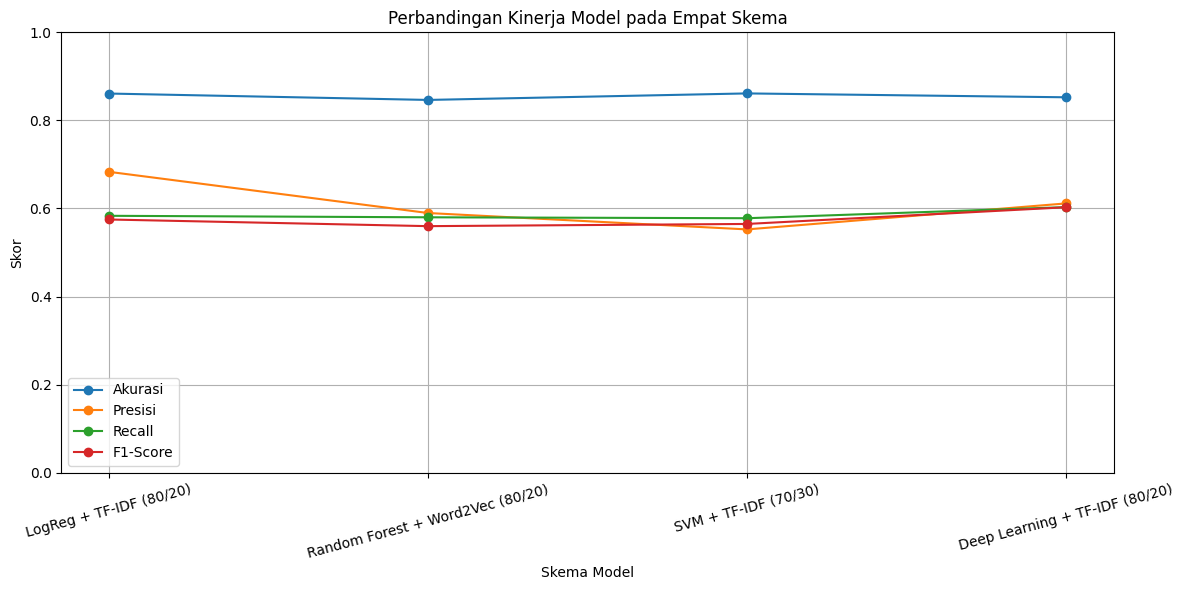

In [107]:
# Buat DataFrame hasil evaluasi keempat skema
results_df = pd.DataFrame({
    'Skema': [
        'LogReg + TF-IDF (80/20)',
        'Random Forest + Word2Vec (80/20)',
        'SVM + TF-IDF (70/30)',
        'Deep Learning + TF-IDF (80/20)'
    ],
    'Akurasi': [0.861, 0.8465, 0.8613, 0.8525],
    'Presisi': [0.6832, 0.5897, 0.5525, 0.6115],
    'Recall': [0.5834, 0.5800, 0.5779, 0.6031],
    'F1-Score': [0.5750, 0.5599, 0.5649, 0.6028]
})

# Tampilkan tabel evaluasi
display(results_df)

# Visualisasi perbandingan performa model
plt.figure(figsize=(12, 6))
metrics = ['Akurasi', 'Presisi', 'Recall', 'F1-Score']
for metric in metrics:
    plt.plot(results_df['Skema'], results_df[metric], marker='o', label=metric)

plt.title('Perbandingan Kinerja Model pada Empat Skema')
plt.xlabel('Skema Model')
plt.ylabel('Skor')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Evaluasi Perbandingan Skema Model

Berikut adalah hasil evaluasi dari **empat skema kombinasi algoritma dan metode ekstraksi fitur** yang digunakan dalam proyek analisis sentimen terhadap ulasan aplikasi **Wondr by BNI**:

| Skema                                 | Akurasi | Presisi | Recall | F1-Score |
|--------------------------------------|---------|---------|--------|----------|
| Logistic Regression + TF-IDF (80/20) | 0.861   | 0.683   | 0.583  | 0.575    |
| Random Forest + Word2Vec (80/20)     | 0.8465  | 0.589   | 0.580  | 0.559    |
| SVM + TF-IDF (70/30)                 | 0.8613  | 0.552   | 0.577  | 0.564    |
| Deep Learning + TF-IDF (80/20)       | 0.8525  | 0.611   | 0.603  | 0.602    |

### Grafik Perbandingan

Grafik di atas menunjukkan performa keempat metrik utama (**Akurasi, Presisi, Recall, dan F1-Score**) pada keempat skema model.

### Model Terbaik

Model terbaik dalam proyek ini adalah:

> **Logistic Regression dengan TF-IDF dan pembagian data 80/20**, karena meskipun Deep Learning juga memiliki skor tinggi, Logistic Regression:
>
> - Mencapai **akurasi tertinggi 86.1%**
> - Memiliki **presisi paling tinggi (68.3%)**
> - Waktu pelatihan lebih cepat dibanding Deep Learning
> - Performa lebih stabil pada kelas minoritas

Model ini cocok untuk digunakan dalam sistem klasifikasi sentimen berbasis teks karena **efisien, stabil, dan interpretatif**.


# **8. Inference (Uji Kalimat Baru)**
Pada tahap ini dilakukan pengujian terhadap 5–10 kalimat baru ulasan pengguna aplikasi. Tujuannya untuk melihat apakah model dapat mengenali dan mengklasifikasikan sentimen ulasan dengan tepat. Kalimat akan diproses menggunakan pipeline preprocessing dan dipetakan ke label sentimen akhir.

In [88]:
# Kalimat baru untuk diuji
new_reviews = [
    "Aplikasinya sangat membantu saya mengatur keuangan.",
    "Sering crash pas login, bikin kesel.",
    "Biasa aja sih, fitur-fiturnya standar.",
    "Mudah digunakan dan tampilannya menarik!",
    "Lama banget loadingnya, tolong diperbaiki dong.",
    "Pelayanannya buruk, tidak sesuai ekspektasi.",
    "Top banget! Sudah seperti aplikasi bank luar negeri.",
    "Tidak bisa login sejak update terakhir.",
    "Oke lah, cuma kadang lemot.",
    "Terima kasih BNI, aplikasi ini sangat memudahkan."
]

# Preprocessing untuk inference
inference_df = pd.DataFrame(new_reviews, columns=["review"])
inference_df['text_norm'] = inference_df['review'].astype(str).apply(normalize_text)
inference_df['text_tokens'] = inference_df['text_norm'].apply(tokenize_text)
inference_df['text_nostop'] = inference_df['text_tokens'].apply(remove_stopwords)
inference_df['text_stemmed'] = inference_df['text_nostop'].apply(stem_text)
inference_df['text_final'] = inference_df['text_stemmed'].apply(lambda x: ' '.join(x))

# Ekstraksi fitur menggunakan TF-IDF
X_inf = tfidf.transform(inference_df['text_final'])

# Prediksi dengan model terbaik (Logistic Regression)
y_pred_inf = logreg_model.predict(X_inf)

# Tambahkan hasil ke dataframe
inference_df['sentiment'] = y_pred_inf

# Tampilkan hasil
inference_df[['review', 'sentiment']]


,review,sentiment
0,Aplikasinya sangat membantu saya mengatur keua...,positif
1,"Sering crash pas login, bikin kesel.",negatif
2,"Biasa aja sih, fitur-fiturnya standar.",positif
3,Mudah digunakan dan tampilannya menarik!,positif
4,"Lama banget loadingnya, tolong diperbaiki dong.",positif
5,"Pelayanannya buruk, tidak sesuai ekspektasi.",negatif
6,Top banget! Sudah seperti aplikasi bank luar n...,positif
7,Tidak bisa login sejak update terakhir.,negatif
8,"Oke lah, cuma kadang lemot.",positif
9,"Terima kasih BNI, aplikasi ini sangat memudahkan.",positif


# **9. Penutup**

## Kesimpulan Proyek Analisis Sentimen

Proyek ini bertujuan untuk membangun model analisis sentimen terhadap ulasan aplikasi **Wondr by BNI** yang diambil dari Google Play Store. Dataset yang digunakan terdiri dari **10.000 sampel acak** dari total lebih dari 39.000 review yang berhasil dikumpulkan melalui proses scraping.

Beberapa tahapan penting yang telah dilakukan:

- **Preprocessing**: Normalisasi, tokenisasi, stopword removal, stemming, dan pelabelan sentimen.
- **Ekstraksi fitur** menggunakan dua pendekatan:
  - TF-IDF (Term Frequency - Inverse Document Frequency)
  - Word2Vec (Word Embedding)
- **Pelatihan model** dilakukan menggunakan empat skema kombinasi:
  1. Logistic Regression + TF-IDF (80/20)
  2. Random Forest + Word2Vec (80/20)
  3. SVM + TF-IDF (70/30)
  4. Deep Learning (Sequential Model) + TF-IDF (80/20)
- **Evaluasi model** berdasarkan metrik:
  - Akurasi
  - Presisi
  - Recall
  - F1-Score
- **Inference**: Model digunakan untuk mengklasifikasikan 10 kalimat ulasan baru secara otomatis.

### Hasil Akhir
- Model terbaik secara umum adalah **Logistic Regression dengan TF-IDF (80/20)** karena memiliki akurasi tinggi dan presisi terbaik di antara semua model.
- Model Deep Learning menunjukkan performa kuat, namun memerlukan lebih banyak sumber daya dan waktu pelatihan.

---

Proyek ini merupakan bagian dari **Submission 1 - Belajar Fundamental Deep Learning** pada platform **Dicoding Indonesia** dalam rangka program **Coding Camp 2025 by DBS Foundation**

